In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [56]:
income = pd.read_csv("C:/Users/61051/Machine Learning/assignment/week 1/income.csv")
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [57]:
# missing values
income = income.replace(" ?", np.nan)
missing_sum = income.isnull().sum().sort_values(ascending=False)
missing_sum

occupation        1843
workclass         1836
native_country     583
high_income          0
hours_per_week       0
capital_loss         0
capital_gain         0
sex                  0
race                 0
relationship         0
marital_status       0
education_num        0
education            0
fnlwgt               0
age                  0
dtype: int64

In [58]:
# dealing with native country
income.native_country.fillna(income.native_country.mode()[0], inplace=True)

# dealing with workclass
income.workclass.fillna(income.workclass.mode()[0], inplace=True)

# dealing with occupation
income.occupation.fillna(income.occupation.mode()[0], inplace=True)
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Text(0.5, 0, 'hours_per_week')

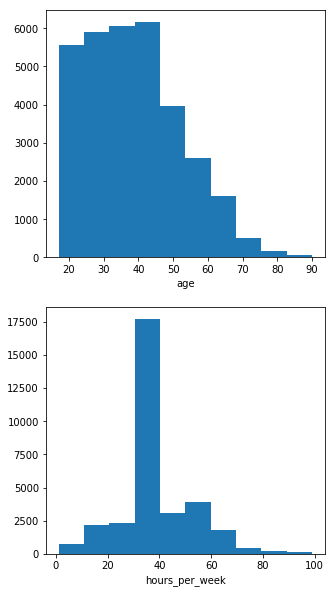

In [59]:
#categorize "high_income"
income["over50K"] = income["high_income"].apply(lambda x: 0 if x==" <=50K" else 1)

# feature engineering&plot
# age/hours_per_week
fig = plt.figure(figsize=(5,10))
ax1 = fig.add_subplot(2,1,1)
ax1.hist(income.age)
ax1.set_xlabel("age")

ax2 = fig.add_subplot(2,1,2)
ax2.hist(income.hours_per_week)
ax2.set_xlabel("hours_per_week")

<BarContainer object of 6 artists>

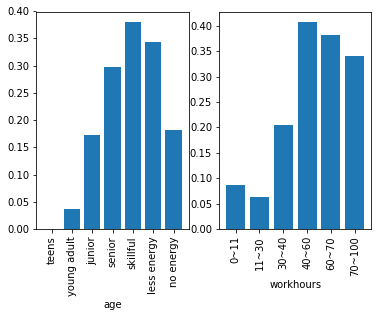

In [60]:
income["age_category"] = pd.cut(income.age, bins=[10,20,26,32,40,50,68,100], 
                                labels=["teens","young adult", "junior", "senior", "skillful", "less energy", "no energy"])

income["hours_cat"] = pd.cut(income.hours_per_week, bins=[0,11,30,40,60,70,100], 
                                  labels=["0~11", "11~30", "30~40", "40~60","60~70", "70~100"])

# plot age_category&hours_per_week vs over50k
pivot_age = income.pivot_table(index="age_category", values="over50K")
pivot_hours = income.pivot_table(index="hours_cat", values="over50K")

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.set_xticklabels(labels=pivot_age.index,rotation=90)
ax1.set_xlabel("age")
ax1.bar(pivot_age.index,pivot_age.over50K)

ax2 = fig.add_subplot(1,2,2)
ax2.set_xticklabels(labels=pivot_hours.index,rotation=90)
ax2.set_xlabel("workhours")
ax2.bar(pivot_hours.index,pivot_hours.over50K)

In [61]:
# work_class 
income["workclass_cat"] = income.workclass.map({' Private':1, " Self-emp-not-inc":2, " Local-gov":3,
                                                    " State-gov":4, " Self-emp-inc":5, " Federal-gov":6,
                                                    " Without-pay":7, " Never-worked":8})

# # marital status
income["marital_status_cat"] = income.marital_status.map({" Married-civ-spouse":1, " Never-married":2, " Divorced":3,
                                                              " Separated":4, " Widowed":5, " Married-spouse-absent":6, " Married-AF-spouse":7})

# age category
income["age_cat_num"] = income.age_category.map({"teens": 1, "young adult": 2, "junior": 3, "senior": 4, "skillful": 5, "less energy": 6,
                                                "no energy": 7})

# hours category
income["hours_cat_num"] = income.hours_cat.map({"0~11":1, "11~30":2, "30~40":3, "40~60":4, "60~70":5, "70~100":6})

# occupation, relationship, race, sex, native_country
columns = ["occupation", "relationship", "race", "sex", "native_country"]
lbl = LabelEncoder()
for c in columns:
    lbl.fit(income[c])
    income[c] = lbl.transform(income[c])

income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,hours_per_week,native_country,high_income,over50K,age_category,hours_cat,workclass_cat,marital_status_cat,age_cat_num,hours_cat_num
0,39,State-gov,77516,Bachelors,13,Never-married,0,1,4,1,...,40,38,<=50K,0,senior,30~40,4,2,4,3
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,3,0,4,1,...,13,38,<=50K,0,skillful,11~30,2,1,5,2
2,38,Private,215646,HS-grad,9,Divorced,5,1,4,1,...,40,38,<=50K,0,senior,30~40,1,3,4,3
3,53,Private,234721,11th,7,Married-civ-spouse,5,0,2,1,...,40,38,<=50K,0,less energy,30~40,1,1,6,3
4,28,Private,338409,Bachelors,13,Married-civ-spouse,9,5,2,0,...,40,4,<=50K,0,junior,30~40,1,1,3,3


In [62]:
income["investment"] = income.capital_gain + income.capital_loss
income.investment = income.investment.apply(lambda x: 1 if x > 0 else 0)
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,native_country,high_income,over50K,age_category,hours_cat,workclass_cat,marital_status_cat,age_cat_num,hours_cat_num,investment
0,39,State-gov,77516,Bachelors,13,Never-married,0,1,4,1,...,38,<=50K,0,senior,30~40,4,2,4,3,1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,3,0,4,1,...,38,<=50K,0,skillful,11~30,2,1,5,2,0
2,38,Private,215646,HS-grad,9,Divorced,5,1,4,1,...,38,<=50K,0,senior,30~40,1,3,4,3,0
3,53,Private,234721,11th,7,Married-civ-spouse,5,0,2,1,...,38,<=50K,0,less energy,30~40,1,1,6,3,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,9,5,2,0,...,4,<=50K,0,junior,30~40,1,1,3,3,0


In [52]:
df = pd.pivot_table(data=income, index=["age_category"],values=["over50K"], columns="hours_cat")
# df.index.name=None

pandas.core.frame.DataFrame

In [38]:
df1 = income.groupby(by=["age_category","sex"]).agg("mean")
df1.index.name=None
df1

TypeError: 'NoneType' object does not support item assignment

In [63]:
# drop the columns
# prepare to predict
income_1 = income.drop(columns=["workclass","hours_cat","fnlwgt", "education", "marital_status", "capital_gain", "capital_loss", "hours_per_week",
                    "high_income", "age_category"], axis=1)

features = income_1.columns.drop("over50K")
target = "over50K"

# split income as train&test
ntrain = round(income_1.shape[0] * 0.8)
train = income_1[:ntrain]
test = income_1[ntrain:]
train.head()

,age,education_num,occupation,relationship,race,sex,native_country,over50K,workclass_cat,marital_status_cat,age_cat_num,hours_cat_num,investment
0,39,13,0,1,4,1,38,0,4,2,4,3,1
1,50,13,3,0,4,1,38,0,2,1,5,2,0
2,38,9,5,1,4,1,38,0,1,3,4,3,0
3,53,7,5,0,2,1,38,0,1,1,6,3,0
4,28,13,9,5,2,0,4,0,1,1,3,3,0


In [64]:
# split on train
train_X, test_X, train_y, test_y = train_test_split(train[features], train[target], test_size=0.2, random_state=42)

# model:decision tree classifier
clf = DecisionTreeClassifier()
cv_auc = cross_val_score(clf, train_X, train_y, cv=5, scoring="roc_auc").mean()

clf.fit(train_X, train_y)
predictions = clf.predict(test[features])
accuracy = roc_auc_score(test[target], predictions)
print("decision tree cv_auc score: {:.4f}\ndecision tree auc {:.4f}".format(cv_auc, accuracy))

# using gridsearchcv to find best model parameters
hyperparameter = {
    "max_depth": list(range(1,8)),
    "min_samples_split":list(range(5,20)),
    "min_samples_leaf": list(range(5,15))
}

clf1 = DecisionTreeClassifier()
grid = GridSearchCV(clf1, param_grid=hyperparameter,cv=5, scoring="roc_auc")
grid.fit(train_X,train_y)
score = grid.best_score_
score

decision tree cv_auc score: 0.7255
decision tree auc 0.7075


0.8834931670963058

In [65]:
best_params = grid.best_params_
best_params

{'max_depth': 7, 'min_samples_leaf': 11, 'min_samples_split': 10}

In [56]:
# using best params
clf2 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=11, min_samples_split=19)
clf2.fit(train_X, train_y)
predictions = clf2.predict(test[features])
score_best = roc_auc_score(test[target], predictions)
print("best GridSearchScore {:.4f}\nbest score {:.4f}".format(score, score_best))

# grid search for random forest
# hyperparameter = {
#     "n_estimators":list(range(200,201)),
#     "max_depth": list(range(1,9)),
#     "min_samples_split":list(range(5,20)),
#     "min_samples_leaf": list(range(5,15))
# }


# grid score result:grid_RFScore
# grid_RF = GridSearchCV(RandomForestClassifier(),param_grid=hyperparameter, cv=5, scoring="roc_auc")
# grid_RF.fit(train_X, train_y)
# grid_RFScore = grid_RF.best_score_
# print("RandomForest score {:.4f}".format(grid_RFScore))

best GridSearchScore 0.8835
best score 0.7482


In [ ]:
# param_RF = grid_RF.best_params_
# param_RF

In [67]:
# using best parameters for RF
clf_RF = RandomForestClassifier(n_estimators=200, max_depth=30,min_samples_leaf=10)
clf_RF.fit(train_X ,train_y)
predictions = clf_RF.predict(test[features])
RF_best = roc_auc_score(test[target], predictions)
print("best randomforest score {:.4f}".format(RF_best))

best randomforest score 0.7567


In [68]:
# using the GBClassifier
gb_clf = GradientBoostingClassifier(learning_rate=0.01, n_estimators=2000, max_depth=10, min_samples_leaf=10)
gb_clf.fit(train_X, train_y)
predicitons = gb_clf.predict(test[features])
gb_score = roc_auc_score(test[target], predictions)
print("GradientBoosting score {:.4f}".format(gb_score))

GradientBoosting score 0.7075
